In [1]:
import os
import random
from operator import itemgetter
from typing import List, Tuple, Any, TypeVar
from pathlib import Path
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy.stats import randint, uniform, loguniform
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             average_precision_score, roc_auc_score, classification_report)

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

SEED = 42
T = TypeVar("T", bound="DataCleaner")

In [2]:
# nltk.download('stopwords')
# nltk.download('wordnet')

# Utilities

In [139]:
random.sample(range(len(X_train)), k=2)

[60, 5418]

In [140]:
def display_random_sample(data: List[str],
                          target_variable: np.ndarray,
                          labels: List[str],
                          n_samples: int = 1,
                          target_class: str = None
                         ) -> List[int]:
    """Easy display random sample(s) from all the data or from a selected class"""
    if target_class is not None:
        filtered_indices = [i for i, label in enumerate(target_variable)
                            if label == target_class]
        if not filtered_indices:
            print(f"No samples found for class {target_class}")
            return
        data = list(itemgetter(*filtered_indices)(data))
        target_variable = list(itemgetter(*filtered_indices)(target_variable))
    
    sampled_indices = random.sample(range(len(data)), k=n_samples)
    
    for i in sampled_indices:
        label = labels[target_variable[i]]
        print(f"Label: {label}\n\nMessage:\n{data[i]}\n")

    return sampled_indices


def check_empty_samples(X_train: List[str],
                        X_test: List[str]
                       ) -> Tuple[np.ndarray]:
    """Check if there are any empty strings in data."""
    empty_train_indices = [idx for idx, string in enumerate(X_train)
                           if string in ["", " "]]
    empty_test_indices = [idx for idx, string in enumerate(X_test)
                          if string in ["", " "]]
    
    return empty_train_indices, empty_test_indices


def remove_empty_samples(X: List[str], y: np.ndarray, indices: List[int]
                        ) -> Tuple[List[str], np.ndarray]:
    """Remove empty string samples."""
    X, y = X.copy(), y.copy()
    for idx in reversed(indices):
        del X[idx]
        y = np.delete(y, idx)

    return X, y


class DataCleaner:
    """
    A class for cleaning and preprocessing textual data.

    Parameters:
    - data: List of strings containing text data.
    - to_remove_patterns: List of regex patterns to remove from data.
    - to_remove_words: List of specific words to remove from data.
    - token_pattern: Regex pattern to tokenize words.
    """
    def __init__(self,
                 data: List[str] = None,
                 to_remove_patterns: List[str] = [],
                 to_remove_words: List[str] = [],
                 token_pattern: str = r"(?u)\b\w[\w']*\b"
                ) -> None:
        """Initialize DataCleaner object."""
        self.data = data.copy() if data is not None else None
        self.to_remove_patterns = to_remove_patterns
        self.to_remove_words = to_remove_words
        self.token_pattern = token_pattern
        self.stop_words = stopwords.words("english")
        self.lemmatizer = WordNetLemmatizer()

    def remove_substrings_from_patterns(self: T) -> T:
        "Remove substrings found as unwanted token patterns."
        for pattern in self.to_remove_patterns:
            self.data = [pattern.sub("", message) for message in self.data]

        return self
    
    def remove_substrings_from_list(self: T) -> T:
        """Tokenize, remove unwanted words and lowercase all."""
        pre_cleaned = []
        
        for message in self.data:
            tokens = re.findall(self.token_pattern, message)
            cleaned_message = [w.lower() for w in tokens
                               if w.lower() not in self.stop_words + self.to_remove_words]
            pre_cleaned.append(cleaned_message)

        self.data = pre_cleaned
    
        return self       
    
    def lemmatize_data(self: T) -> T:
        """Lemmatize tokenized messages and join into strings."""
        for i in range(len(self.data)):
            lemmatized_message = [self.lemmatizer.lemmatize(token) for token in self.data[i]]
            self.data[i] = " ".join(lemmatized_message)
    
        return self

    def transform(self: T, data: List[str] = None) -> List[str]:
        """Transform data with cleaning and lemmatization"""
        if data is not None:
            self.data = data.copy()
        self.remove_substrings_from_patterns()
        self.remove_substrings_from_list()
        self.lemmatize_data()
        
        return self.data


def get_metrics(cv_results: dict,
                main_metric: str = None,
                other_metrics: List[str] = None
               ) -> dict:
    """Get metrics from `cv_results_` dict provided by RandomizedSearchCV optimizer."""
    metrics = {}
    if main_metric is None:
        main_metric = "f1_macro"
    if other_metrics is None:
        other_metrics = ["f1_weighted", "accuracy"]
    
    best_index = np.argmax(cv_results[f"mean_test_{main_metric}"])

    best_score = cv_results[f"mean_test_{main_metric}"][best_index]
    best_score_train = cv_results[f"mean_train_{main_metric}"][best_index]

    metrics[main_metric] = best_score
    metrics[f"{main_metric}_train"] = best_score_train

    for metric in other_metrics:
        corresponding_metric_test = cv_results[f"mean_test_{metric}"][best_index]
        corresponding_metric_train = cv_results[f"mean_train_{metric}"][best_index]
        metrics[metric] = corresponding_metric_test
        metrics[f"{metric}_train"] = corresponding_metric_train

    metrics["time[s]"] = np.round((cv_results["mean_fit_time"][best_index]
                                   + cv_results["mean_score_time"][best_index]).mean(), 2)

    return metrics


def load_results(endswith: str,
                 directory: str = "results"
                ) -> Tuple[List[Any], List[str]]:
    """Load objects from files with specified filename ending in the given directory."""
    object_list = []
    name_list = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(endswith):
                file_path = os.path.join(root, file)
                object_ = load(file_path)
                object_list.append(object_)
                
                subfolder = os.path.basename(root)
                file_prefix = file[:3]
                name = f"{subfolder}_{file_prefix}"
                name_list.append(name)

    return object_list, name_list

# The dataset

In [4]:
loading_data_params = {"remove": ("headers", "footers", "quotes"),
                       "return_X_y": True,
                       "random_state": SEED}

train = fetch_20newsgroups(data_home="data/train", subset="train")
X_train, y_train = fetch_20newsgroups(data_home="data/train", subset="train", **loading_data_params)
X_test, y_test = fetch_20newsgroups(data_home="data/test", subset="test", **loading_data_params)

## Content

In [5]:
print(train.DESCR[26:395])
print(train.DESCR[846:1050])


The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1
Features                  text


In [6]:
labels = dict(zip(range(20), train.target_names))
pd.DataFrame.from_dict(labels, orient="index", columns=["target_name"])

,target_name
0,alt.atheism
1,comp.graphics
2,comp.os.ms-windows.misc
3,comp.sys.ibm.pc.hardware
4,comp.sys.mac.hardware
5,comp.windows.x
6,misc.forsale
7,rec.autos
8,rec.motorcycles
9,rec.sport.baseball


In [141]:
# a function for convenient data browsing
_ = display_random_sample(X_train, y_train, labels, n_samples=1, target_class=None)

Label: misc.forsale

Message:
10 month old stereo system for sale. Luxman R-351 receiver, Onkyo TA-RW404
tape deck, and Polk Monitor M4.6 book shelf speakers are for sale. Receiver
has 5 year warranty, and all equipment is in excellent condition. Paid $950
for the system and willing to consider the best offer. Will sell seperate
pieces also if desired. Please send best offer to suraj@cs.jhu.edu.

Speakers: Polk Monitor M4.6 bookshelf speakers
	  Paid $250 pair. Willing to consider best offer.

Receiver: Luxman R-351 receiver with 5 year (yes 5 years) warranty.
	  Paid $475. Willing to consider best offer.
	  Full remote, 2 pairs of speaker connections,
	  60 watts per channel, but drives like a 150 watts per channel
	  Has all the standard features, and more.

Tape Deck: Onkyo TA-RW404 tape deck
	   Paid $275. Willing to consider best offer.
	   Dual cassette, Dolby B, C, and HX Pro.
	   Input level control for recording, auto reverse both sides.
           Has all standard features.



## Data issues

Although headers, footers, and block quotes were omitted during loading, we identified the following issues in the data:

* empty strings
* mixtures of letters and numbers, such as n3jpx, x11r5
* communication protocol headers like nntp, IP addresses
* words related to message organization, such as: "re", "subject", "organization", "lines", "from", "date", "references", "message", "id", "voice", "fax", "email", "mail"
* email addresses, phone numbers, fax numbers
* names of institutions/companies, addresses, first and last names

## Initial cleaning

Removing samples with empty strings

In [7]:
empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 226 empty strings
X_test: 163 empty strings


In [8]:
X_train, y_train = remove_empty_samples(X_train, y_train, empty_train_indices)
X_test, y_test = remove_empty_samples(X_test, y_test, empty_test_indices)

empty_train_indices, empty_test_indices = check_empty_samples(X_train, X_test)
print(f"X_train: {len(empty_train_indices)} empty strings\nX_test: {len(empty_test_indices)} empty strings")

X_train: 0 empty strings
X_test: 0 empty strings


## Class distribution

Our classes are fairly balanced, but we have slightly fewer observations in some categories (as shown below). To see if this affects the results, we add a `class_weight` option in the hyperparameter optimization, and use `F1 weighted` as an additional metric.

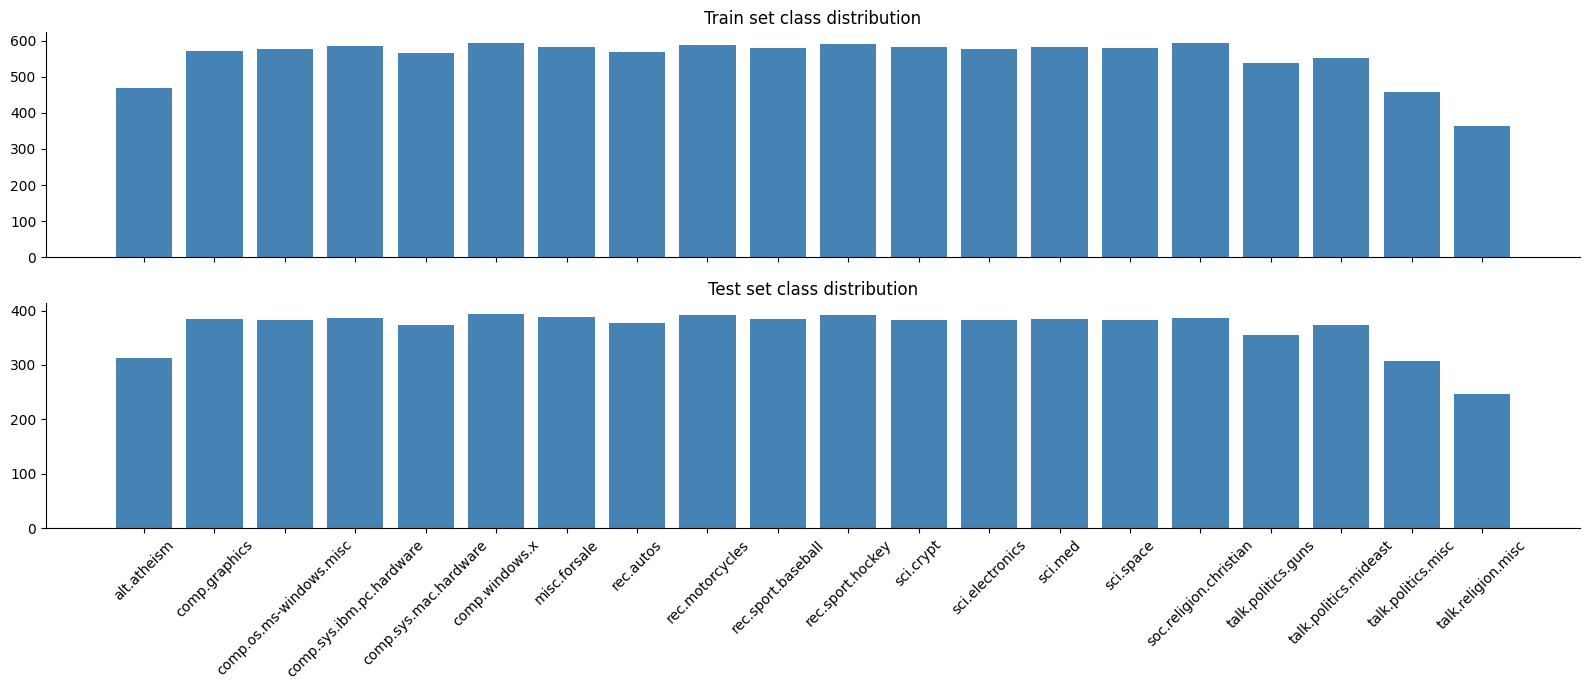

In [9]:
unique, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

fig, axs = plt.subplots(2, 1, figsize=(16, 7), sharex=True)
axs[0].bar(train.target_names, counts_train, color="steelblue")
axs[0].set_title("Train set class distribution")
axs[1].bar(train.target_names, counts_test, color="steelblue")
axs[1].set_title("Test set class distribution")
axs[1].set_xticks(ticks=unique, labels=train.target_names, rotation=45)
plt.tight_layout();

# Data preparing

We created the `DataCleaner` class for convenient transforming our data.

We used regular expressions to remove email adresses, nntp protocol info, numbers and words which are combinations of numbers and letters. We also removed non-informative words we found (like related to messages organization or stop words we didn't find in the list provided by `nltk`).

As seen below, data cleaning and lemmatization resulted in a reduction of almost 40% in the number of features.

In [10]:
email_pattern = re.compile("[\w\.]+@\w+\.\w+[\w\.]*")
nntp_pattern = re.compile(r"\b\w*(?:nntp|NNTP)\w*\b")
num_seq_pattern = re.compile(r'\b\d+\b')
num_with_letters = re.compile(r'\b(?=\w*\d)(?=\w*[a-zA-Z])\w{3,}\b')
words_to_remove = ["re", "subject", "organization", "lines", "from", "date",
                   "references", "message", "id", "voice", "fax", "email", "mail",
                   "i'm", "i've", "i'd", "can't", "can"]

cleaner = DataCleaner(to_remove_patterns=[email_pattern,
                                          nntp_pattern,
                                          num_seq_pattern,
                                          num_with_letters],
                      to_remove_words=words_to_remove)

cleaned_X_train = cleaner.transform(X_train)
cleaned_X_test = cleaner.transform(X_test)

In [11]:
vectorizer = TfidfVectorizer()
print(f"Number of unigram features before cleaning: {len(vectorizer.fit(X_train).get_feature_names_out())}")
print(f"After cleaning and lemmatization: {len(vectorizer.fit(cleaned_X_train).get_feature_names_out())}")

Number of unigram features before cleaning: 101631
After cleaning and lemmatization: 63099


## Cleaned data examples

Below one can see examples of the effects of our feature transformation - it's not perfect, but we seem to have achieved more or less what we wanted. This should improve the efficiency of the algorithms and also speed up the training process.

In [97]:
bold = "\033[1m"
end_bold = "\033[0m"

for i in random.sample(range(len(X_train)), k=2):
    print(f"{bold}Original message:{end_bold}\n:", X_train[i])
    print(f"{bold}Cleaned message:{end_bold}\n:", cleaned_X_train[i])
    print("-"*72)

Original message:
: Actually, there can be any number of players on a side. You can
have a 25-man roster, a 40-man roster, etc....

Ryan Robbins
Penobscot Hall
University of Maine
Cleaned message:
: actually number player side man roster man roster etc ryan robbins penobscot hall university maine
------------------------------------------------------------------------
Original message:
: Well, it now seems obvious what Professor Denning was doing last fall
when this key escrow trial balloon was raised!

All the more need for end-to-end encryption schemes that bypass the
government-approved system.

By the way, the "Clipper" name...isn't this already used for the
Clipper processor from Intergraph? I doubt they're the ones making the
chip, so a name conflict may be present.

-Tim May

Cleaned message:
: well seems obvious professor denning last fall key escrow trial balloon raised need end end encryption scheme bypass government approved system way clipper name already used clipper proce

# Experiments

We want to test **two approaches**:
* the first one: cleaned and lemmatized data with feature selection using chi square test
* the second one: unchanged data with feature selection by `TfidfVectorizer` parameters

Thus, **we want to find out whether careful data preparation and feature selection will yield clearly better results than a "lazy" approach**.

We optimized hyperparameters by randomized search with 5-fold cross validion. Our main scoring metric is `F1 macro` (the average `F1 score` of all classes), as we want to have accurate predictions for all of 20 classes. To see bigger picture, we also saved `F1 weighted`, to verify if a little class imbalance affects our scores, and general accuracy. We checked also metrics for training set, to see if our models are prone to overfitting.

## Defining Pipeline and hyperparameters grids

In [19]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer()),
    ("selector", "passthrough"),
    ("model", "passthrough")
])

chi2_selection_grid = {
    "vectorizer__stop_words": [None], # no need to remove stop_words, we did it before lemmatization
    "selector": [SelectKBest(chi2)],
    "selector__k": randint(1000, 5000)
}

vectorizer_selection_grid = {
    "vectorizer__ngram_range": [(1, 1), (1, 2)],
    "vectorizer__stop_words": ["english", None],
    "vectorizer__min_df": randint(1, 5),
    "vectorizer__max_df": uniform(0.5, 0.5),
    "vectorizer__max_features": randint(1000, 5000)
}

mnb_base_grid = {
    "model": [MultinomialNB()],
    "model__alpha": uniform(0.5, 0.5),
}

svm_base_grid = {
    "model": [SVC(random_state=SEED)],
    "model__kernel": ["linear"],
    "model__C": loguniform(1e-4, 1e1),
    "model__class_weight": ["balanced", None]
}

mnb_grids = [
    {
        **mnb_base_grid,
        **chi2_selection_grid
    },
    {
        **mnb_base_grid,
        **vectorizer_selection_grid
    }
]

svm_grids = [
    {
        **svm_base_grid,
        **chi2_selection_grid
    },
    {
        **svm_base_grid,
        **vectorizer_selection_grid
    }
]

## Run experiments

* defining cross validation scheme
* designing code to easily test both approaches (and data versions) for both our models with different parameters
* providing `n_iter` parameter depending on model (we set more iterations for `MultinomialNB` as it learns so much faster than `SVC`)
* saving our best models' artifacts and metrics (and cv_results_ for possible analysis if needed)

In [21]:
cv_scheme = KFold(n_splits=5, shuffle=True, random_state=SEED)

for name, grids in zip(["MNB", "SVC"],
                       [mnb_grids, svm_grids]):

    n_iter = 300 if name == "MNB" else 150

    for X, test, grid in zip([cleaned_X_train, X_train],
                             ["cleaned_data", "full_data"],
                              grids):
    
        optimizer = RandomizedSearchCV(pipeline,
                                       grid,
                                       scoring=["f1_macro", "f1_weighted", "accuracy"],
                                       refit="f1_macro",
                                       n_iter=n_iter,
                                       cv=cv_scheme,
                                       return_train_score=True,
                                       n_jobs=-1,
                                       error_score="raise",
                                       verbose=1,
                                       random_state=SEED
                                       )
    
        optimizer.fit(X, y_train)
    
        path = Path("results", test)
        path.mkdir(parents=True, exist_ok=True)
        
        metrics = get_metrics(optimizer.cv_results_)
        model = optimizer.best_estimator_
    
        dump(metrics, f"{path}/{name}_metrics.pkl")
        dump(model, f"{path}/{name}_model.pkl")
        dump(optimizer.cv_results_, f"{path}/{name}_cv_results.pkl")
        
        print(optimizer.best_score_)
        print(optimizer.best_params_)
        print("--------------------")

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.7123846603483618
{'model': MultinomialNB(), 'model__alpha': 0.5194173672147115, 'selector': SelectKBest(score_func=<function chi2 at 0x7a8407786310>), 'selector__k': 4854, 'vectorizer__stop_words': None}
--------------------
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.6865507259852466
{'model': MultinomialNB(), 'model__alpha': 0.6027899041878187, 'vectorizer__max_df': 0.8938949443572461, 'vectorizer__max_features': 4737, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}
--------------------
Fitting 5 folds for each of 150 candidates, totalling 750 fits
0.724761662396663
{'model': SVC(random_state=42), 'model__C': 1.2193011993958955, 'model__class_weight': 'balanced', 'model__kernel': 'linear', 'selector': SelectKBest(score_func=<function chi2 at 0x7a8407786310>), 'selector__k': 4643, 'vectorizer__stop_words': None}
--------------------
Fitting 5 folds f

## Optimization results

The approach with careful data preparation and feature selection gave us noticeably better results and reduced the training time of the models. 

For F1, `SVM` yielded slightly better results, and for accuracy, `MultinomialNB` yielded slightly better results. We can also see that `F1 weighted` is slightly higher than `F1 macro`, so classes with slightly fewer observations are less well predicted (also by the `SVM`, which used class weighting).

Our models appear overfitted, as evidenced by much higher metrics for fit than the average scores for the test sets. However, we were able to reduce this anyway by limiting the number of features to less than 5000, previously our models were fit almost 100% and the test results were similar. Considering the main metric used and that we have as many as 20 classes, the results seem not too bad.

In [23]:
metrics, idxs = load_results(endswith="metrics.pkl")

metrics_df = pd.DataFrame(metrics, index=idxs).round(3)
metrics_df.style.background_gradient()

,f1_macro,f1_macro_train,f1_weighted,f1_weighted_train,accuracy,accuracy_train,time[s]
cleaned_data_MNB,0.712000,0.830000,0.726000,0.839000,0.733000,0.842000,1.930000
cleaned_data_SVC,0.725000,0.887000,0.731000,0.888000,0.728000,0.887000,19.100000
full_data_MNB,0.687000,0.841000,0.700000,0.849000,0.708000,0.852000,2.820000
full_data_SVC,0.679000,0.950000,0.688000,0.951000,0.688000,0.951000,35.880000


# Models' evaluation on test data

In [12]:
models, names = load_results(endswith="model.pkl")

# assigning names to loaded models
for name, model in zip(names, models):
    exec(f"{name} = model")

As we need probabilities to be returned by models to calculate the ROC AUC score and average precision, an additional parameter was set in the SVM, and the SVM models were fitted again. Setting this parameter at the beginning would result in even longer fit and score times, which we didn't want during optimization.

In [13]:
param = {"model__probability": True}

full_data_SVC.set_params(**param)
full_data_SVC.fit(X_train, y_train)

cleaned_data_SVC.set_params(**param)
cleaned_data_SVC.fit(cleaned_X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('selector',
                 SelectKBest(k=4643,
                             score_func=<function chi2 at 0x7bcce12173a0>)),
                ('model',
                 SVC(C=1.2193011993958955, class_weight='balanced',
                     kernel='linear', probability=True, random_state=42))])

In [14]:
all_results = []

for name, model in zip(names, models):

    results = {}
    
    X_train_final = X_train if name.startswith("full") else cleaned_X_train
    X_test_final = X_test if name.startswith("full") else cleaned_X_test
    
    y_fitted = model.predict(X_train_final)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)

    results = {
        "F1_macro": f1_score(y_test, y_pred, average="macro"), 
        "F1_macro_train": f1_score(y_train, y_fitted, average="macro"),
        "F1_weighted": f1_score(y_test, y_pred, average="weighted"),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Avg_precision": average_precision_score(y_test, y_proba, average="macro"),
        "Roc_auc_ovr": roc_auc_score(y_test, y_proba, average="macro", multi_class="ovr"),
        "Roc_auc_ovo": roc_auc_score(y_test, y_proba, average="macro", multi_class="ovo")
    }
    all_results.append(results)

results_df = pd.DataFrame(all_results, index=names).round(3)
results_df.style.background_gradient()

,F1_macro,F1_macro_train,F1_weighted,Accuracy,Avg_precision,Roc_auc_ovr,Roc_auc_ovo
cleaned_data_MNB,0.670000,0.822000,0.685000,0.693000,0.705000,0.957000,0.956000
cleaned_data_SVC,0.660000,0.878000,0.671000,0.666000,0.714000,0.953000,0.952000
full_data_MNB,0.642000,0.829000,0.655000,0.663000,0.693000,0.954000,0.953000
full_data_SVC,0.621000,0.944000,0.631000,0.630000,0.672000,0.945000,0.944000


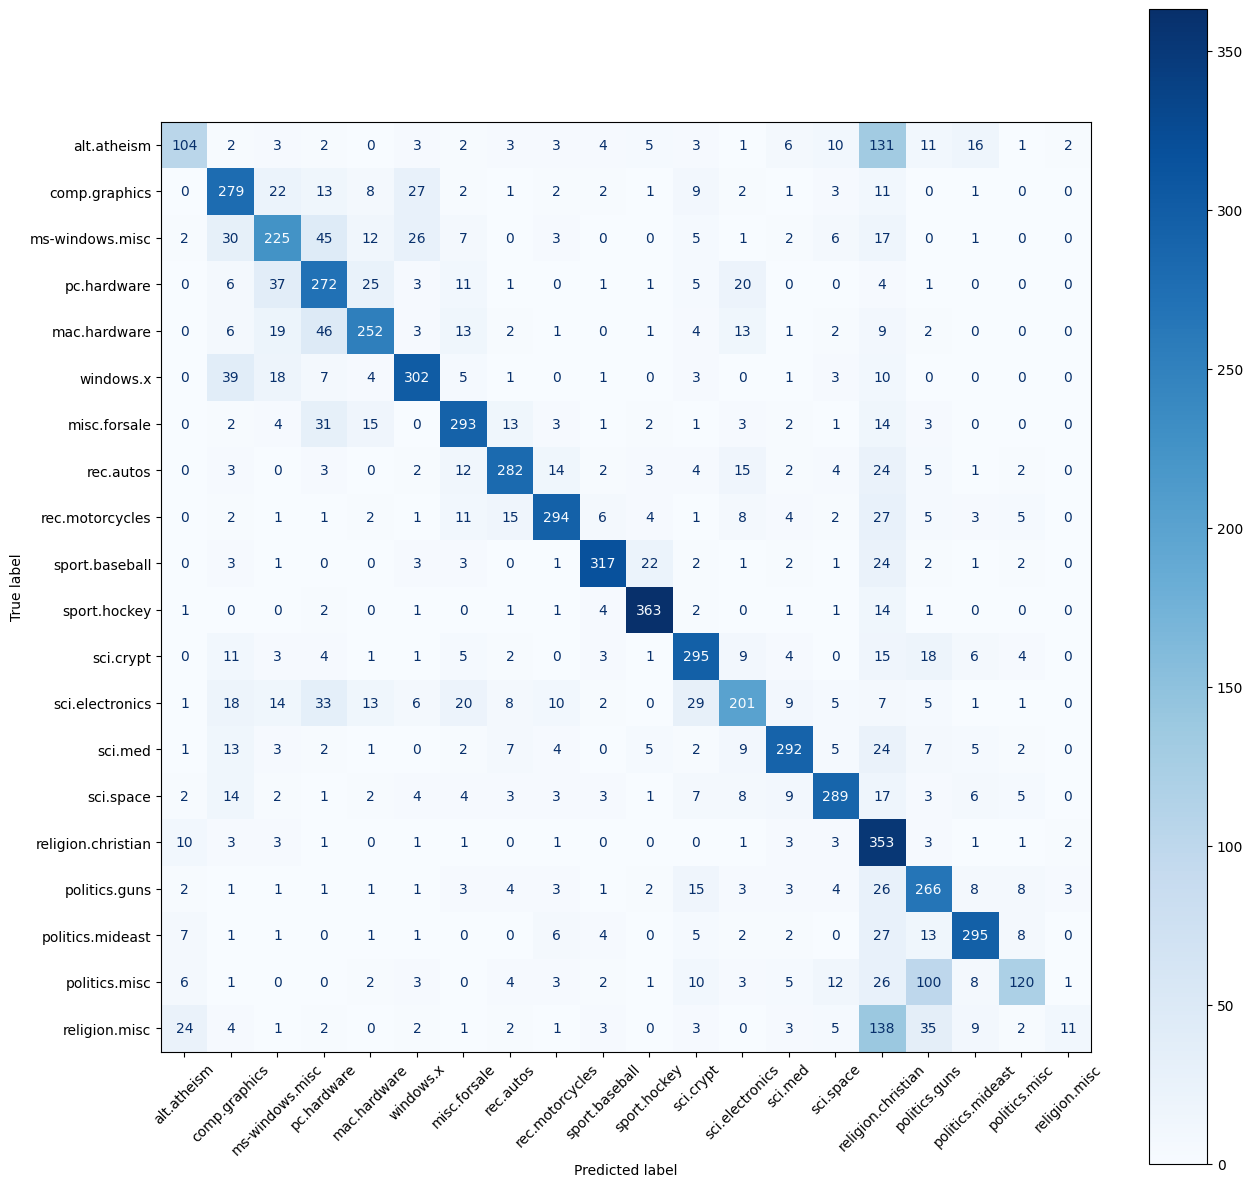

In [86]:
y_pred = cleaned_data_MNB.predict(cleaned_X_test)
cm = confusion_matrix(y_test, y_pred)

short_labels = [".".join((l.split(".")[-2:])) for l in train.target_names]

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ConfusionMatrixDisplay(cm, display_labels=short_labels).plot(cmap="Blues", ax=ax)
plt.gca().spines[["right", "top"]].set_visible(True)
plt.xticks(rotation=45);

## Results

In the end, the best model turned out to be `MultinomialNb` on the prepared data.

For some classes, however, the model is often wrong, but they are usually very similar subjects - `religion.misc` and `alt.atheism` are predicted as `religion.christian`, and `politics.guns` as `politics.misc`. The model is also wrong sometimes for other classes, for example, it confuses classes related in some way to electronics.\
It also just so happened that the worst predicted classes are minority classes.

On the other hand, after the ROC AUC results, we see that the probabilities returned by the model are very well correlated with the real classes, which is a good indication of the quality of our model.

## Digging deeper into the results

### Predictions

The most commonly assigned class by our model is `religion.christian`. Interestingly, this is not only due to confusion between this category and similar ones (such as `alt.atheism` and `religion.misc`), but also this class is sometimes assigned to an observation belonging to any of the real classes.

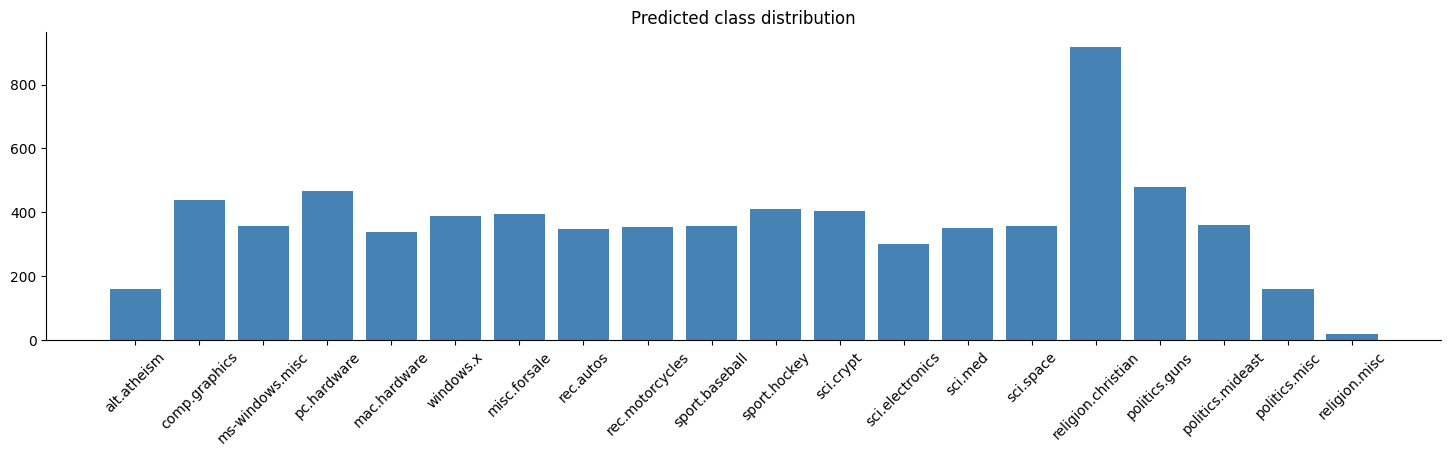

In [112]:
_, counts_preds = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(18, 4))
plt.bar(short_labels, counts_preds, color="steelblue")
plt.xticks(rotation=45)
plt.title("Predicted class distribution");

So we looked at the data again and identified the following possible causes:
* emotionally charged messages from other classes, containing words such as "god," "trust" (**an example below**)
* messages of the `religion.christian` class, not directly related to this topic - perhaps there are many
* there are messages in the data that could belong to any group, so it is not surprising that it is difficult to classify them

In [186]:
fake_christian_idxs = np.where((y_test != 15) & (y_pred == 15))[0].tolist()
filtered_X_test = [X_test[idx] for idx in fake_christian_idxs]
filtered_y_test = y_test[fake_christian_idxs]
filtered_cleaned_X_test = [cleaned_X_test[idx] for idx in fake_christian_idxs]

idx = display_random_sample(filtered_X_test,
                            filtered_y_test,
                            labels,
                            n_samples=1,
                            target_class=None)
print(f"Cleaned message:\n{filtered_cleaned_X_test[idx[0]]}")

Label: talk.politics.guns

Message:

Hmm... For more recent lesson what about that little square in China?

Another lesson might be the one repeated every year in Tibet...

And of course there's always El Salvador...

And the beat goes on and on...     :^(

MESSAGES FROM GOD:  GET OFF YOUR ASS!  DON'T TRUST THE
GOVERNMENT!  AT ANY TIME!  FOR ANY REASON!  -THE SCREAMING MAN
     
CONNECT THE GOD-DAMNED DOTS!!!  Ministry, TV Song


Cleaned message:
hmm recent lesson little square china another lesson might one repeated every year tibet course there's always el salvador beat go message god get as trust government time reason screaming man connect god damned dot ministry tv song


**It is difficult to understand why this type of message (as below) was classified as `religion.christian`.**

In [195]:
idx = display_random_sample(filtered_X_test,
                            filtered_y_test,
                            labels,
                            n_samples=1,
                            target_class=None)
print(f"Cleaned message:\n{filtered_cleaned_X_test[idx[0]]}")

Label: comp.sys.mac.hardware

Message:


Is there any such thing as in inefficient heater?

Cleaned message:
thing inefficient heater


**An example of a message belonging to the `religion.christian` class, and not very associated with this topic**

In [243]:
_ = display_random_sample(X_test,
                            y_test,
                            labels,
                            n_samples=1,
                            target_class=15)

Label: soc.religion.christian

Message:

Robin Lane Fox is a historian and a gardener.  He has written several
history books, perhaps a recent one you might remember is "The Search
for Alexander".  He has also written or edited several books on
gardening.



### Probabilities
The probabilities of belonging to classes for which the model is often wrong indicate high uncertainty for `religion.christian`/`alt.atheist` and an advantage for `religion.christian` over `religion.misc`.\
Hardly surprising though, these are very similar subjects; in addition, the `religion.christian` class was more in the training data.

In [87]:
y_proba = cleaned_data_MNB.predict_proba(cleaned_X_test)
y_proba.shape

(7369, 20)

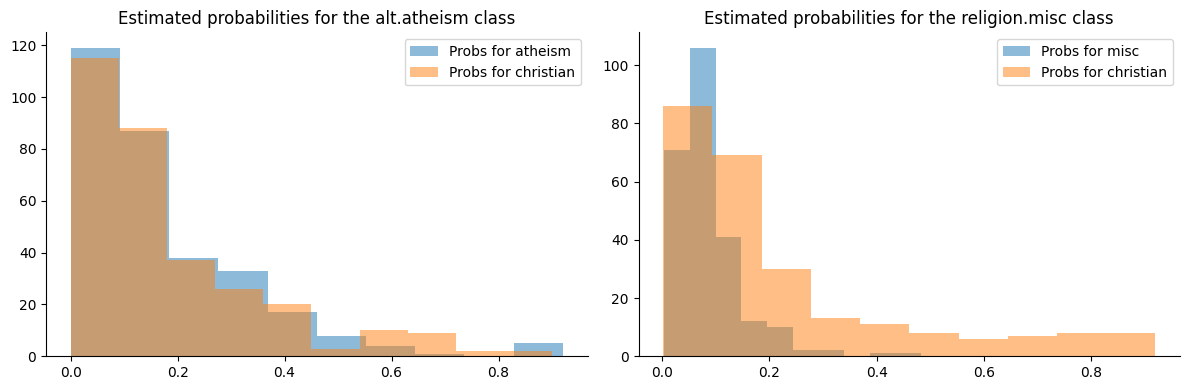

In [103]:
atheism_probs = y_proba[np.where(y_test == 0)]
religion_misc_probs = y_proba[np.where(y_test == 19)]

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(atheism_probs[:, 0], alpha=0.5, label="Probs for atheism")
plt.hist(atheism_probs[:, 15], alpha=0.5, label="Probs for christian")
plt.title("Estimated probabilities for the alt.atheism class")
plt.legend()
plt.subplot(122)
plt.hist(religion_misc_probs[:, 19], alpha=0.5, label="Probs for misc")
plt.hist(religion_misc_probs[:, 15], alpha=0.5, label="Probs for christian")
plt.title("Estimated probabilities for the religion.misc class")
plt.legend()
plt.tight_layout();

### Scores for the classes

Analysis of the metrics for each class confirms all of the above observations. The model performs best in predicting sports topics.

In [89]:
report = classification_report(y_test, y_pred, output_dict=True)

detailed_results = pd.DataFrame(report).T.iloc[:-3, :-1]
detailed_results.index = train.target_names
detailed_results.style.background_gradient()

,precision,recall,f1-score
alt.atheism,0.650000,0.333333,0.440678
comp.graphics,0.636986,0.726562,0.678832
comp.os.ms-windows.misc,0.628492,0.589005,0.608108
comp.sys.ibm.pc.hardware,0.583691,0.702842,0.637749
comp.sys.mac.hardware,0.743363,0.673797,0.706872
comp.windows.x,0.774359,0.766497,0.770408
misc.forsale,0.741772,0.755155,0.748404
rec.autos,0.808023,0.746032,0.775791
rec.motorcycles,0.832861,0.750000,0.789262
rec.sport.baseball,0.890449,0.823377,0.855601


### Most important features

The most informative features for the model look sensible, the vast majority of them associate strongly with any of our classes.\
Unfortunately, our model does not return information with which to determine the most important attributes for each class.

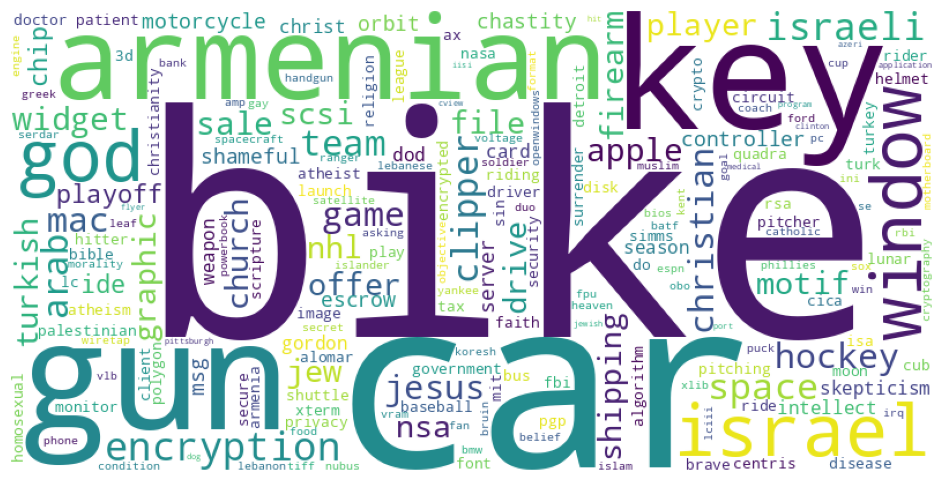

In [100]:
selector = cleaned_data_MNB["selector"]
vectorizer = cleaned_data_MNB["vectorizer"]

feature_names = np.asarray(vectorizer.get_feature_names_out())
top_indices = np.argsort(selector.scores_)[-200:]
top_features = feature_names[top_indices]
top_scores = selector.scores_[top_indices]
feature_scores = dict(zip(top_features, top_scores))

wordcloud = WordCloud(width=800,
                      height=400,
                      background_color="white").generate_from_frequencies(feature_scores)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation=None)
plt.axis("off");

# Summary, conclusions and future work


1. We made a pretty good, fast and light model, but its effectiveness depends on the class. In some cases, our model performs poorly.
2. We conducted an extensive analysis of our dataset and results and described in detail all the steps taken, observations and conclusions.
3. Mesagges from newsgroups can be heavy stuff and often unpredictable, just like discussions between people.
4. We didn't actually have much training data (11 088 samples), perhaps more would have improved our results. On the other hand, our test set was relatively large (7 369 samples) - but we did not change this split scheme proposed by sklearn.
5. Perhaps our results would be better if we had prepared our data even more carefully or used a different feature selection method.
6. Other algorithms could be tested - perhaps in general shallow algorithms are too weak to handle this classification for all of 20 classes with high efficiency.